# Textual-inversion fine-tuning for Stable Diffusion using d🧨ffusers

This notebook shows how to "teach" Stable Diffusion a new concept via textual-inversion using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

![Textual Inversion example](https://textual-inversion.github.io/static/images/editing/colorful_teapot.JPG)
_By using just 3-5 images you can teach new concepts to Stable Diffusion and personalize the model on your own images_

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



## Initial setup

In [1]:
should_skip =

In [2]:
#@title Install the required libs
if not should_skip:
  !pip install -U -qq git+https://github.com/huggingface/diffusers.git
  !pip install -qq accelerate transformers ftfy
  !pip install gpustat gdown

In [3]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TVF
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed

# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py#L175-L182
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Settings for teaching your new concept

In [4]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}

### Get the training images:

#### Download the images from the internet and save them locally.

You can also upload the images to colab or load from google drive, please check the next section if you want to use that.

In [5]:
#@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
urls = [
      "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
      # "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
      # "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
      ## You can add additional images here
]

In [6]:
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]

[None, None]

In [7]:
!gdown --id 1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
mask_path="./my_concept_gt"
!mkdir $mask_path/

with open("my_concept_gt.zip","r") as f:
  pass
!unzip -o my_concept_gt.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
To: /content/my_concept_gt.zip
100% 14.7k/14.7k [00:00<00:00, 38.0MB/s]
mkdir: cannot create directory ‘./my_concept_gt/’: File exists
Archive:  my_concept_gt.zip
  inflating: my_concept_gt/1.png     
  inflating: my_concept_gt/0.png     


#### Load images from local folder or google drive

You can also load your own training images from google drive or upload them to colab usingthe files taband then provide the path to the directory containing images.

*Make sure that the directory only contains images as the following cells will read all the files from the provided directory.*

In [8]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [9]:
# #@markdown `images_path` is a path to directory containing the training images. It could
# images_path = "" #@param {type:"string"}
# while not os.path.exists(str(images_path)):
#   print('The images_path specified does not exist, use the colab file explorer to copy the path :')
#   images_path=input("")
# save_path = images_path

####  Setup and check the images you have just added

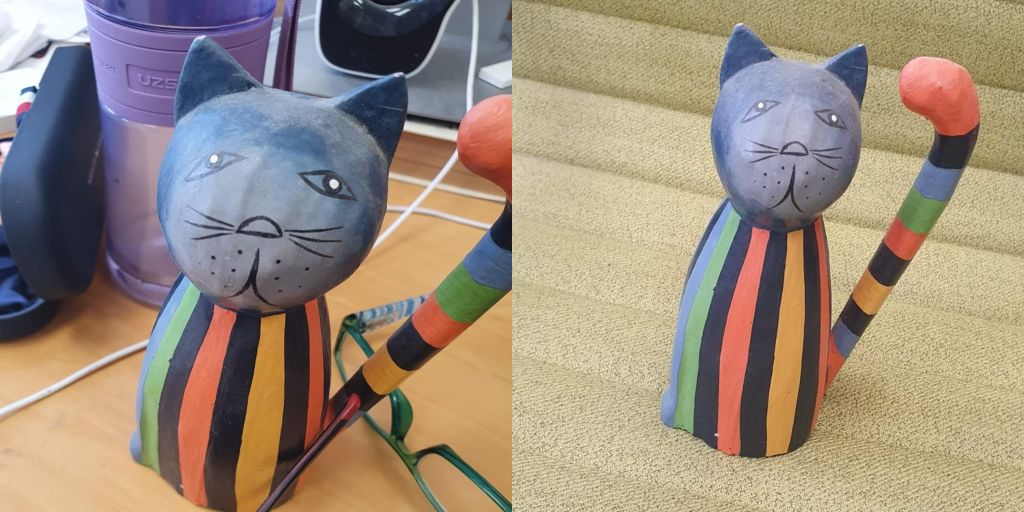

In [10]:
images = []
for file_path in os.listdir(save_path):
  try:
      image_path = os.path.join(save_path, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 1, len(images))

In [11]:
#@title Settings for your newly created concept
#@markdown `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used, `style` allows you to teach the model a new style one can use.
what_to_teach = "object" #@param ["object", "style"]
#@markdown `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token = "<cat-toy>" #@param {type:"string"}
#@markdown `initializer_token` is a word that can summarise what your new concept is, to be used as a starting point
initializer_token = "part" #@param {type:"string"}

## Teach the model a new concept (fine-tuning with textual inversion)
Execute this this sequence of cells to run the training process. The whole process may take from 1-4 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

### Create Dataset

In [12]:
#@title Setup the prompt templates for training
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [13]:
#@title Setup SLiME dataset

class SLiMEDataset(Dataset):
  def __init__(
      self,
      data_root,
      mask_root,
      tokenizer,
      cls_token_ids,
      size=512,
      mask_size=64,
      interpolation="bicubic",
      set="train",
  ):
    self.data_root = data_root
    self.mask_root = mask_root
    self.tokenizer = tokenizer
    self.size = size
    self.mask_size=mask_size

    self.cls_token_ids = cls_token_ids


    self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]
    self.mask_paths = [os.path.join(self.mask_root, file_path) for file_path in os.listdir(self.mask_root)]

    self.num_images = len(self.image_paths)
    self._length = self.num_images

    if set == "train":
      self._length = self.num_images

    self.interpolation = {
      "linear": PIL.Image.LINEAR,
      "bilinear": PIL.Image.BILINEAR,
      "bicubic": PIL.Image.BICUBIC,
      "lanczos": PIL.Image.LANCZOS,
    }[interpolation]


    [self.bos_token,self.eos_token] = self.tokenizer("").input_ids
    print(self.bos_token,self.eos_token)
  def __len__(self):
    return self._length

  def __getitem__(self, i):
    example = {}
    image = Image.open(self.image_paths[i % self.num_images])
    mask = Image.open(self.mask_paths[i % self.num_images])

    if not image.mode == "RGB":
        image = image.convert("RGB")

    input_ids = torch.zeros(len(self.cls_token_ids)+2,dtype=torch.int64)

    assert len(self.cls_token_ids) + 2 < self.tokenizer.model_max_length


    input_ids[0] = self.bos_token
    input_ids[1:len(self.cls_token_ids)+1] = torch.tensor(self.cls_token_ids)
    input_ids[len(self.cls_token_ids)+1] = self.eos_token

    example["input_ids"] = input_ids

    # default to score-sde preprocessing
    img = np.array(image).astype(np.uint8)

    image = Image.fromarray(img)
    image = image.resize((self.size, self.size), resample=self.interpolation)

    image = np.array(image).astype(np.uint8)
    image = (image / 127.5 - 1.0).astype(np.float32)

    example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)

    mask_torch = (TVF.pil_to_tensor(mask.resize((self.mask_size,self.mask_size),resample=self.interpolation))[0] > 0).to(torch.int64)
    mask_torch_oh = F.one_hot(mask_torch,num_classes=2) # hardcode to (background,foreground) for now

    example["gt_masks"] = mask_torch
    example["gt_masks_oh"] = mask_torch_oh
    return example

In [14]:
#@title Setup the dataset
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        cls_token_ids,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.cls_token_ids = cls_token_ids
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        input_ids = torch.zeros(self.tokenizer.model_max_length,dtype=torch.int64)
        empty = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]
        start,end = empty[:2]

        assert len(self.cls_token_ids) + 2 < self.tokenizer.model_max_length

        input_ids[0] = start
        input_ids[1:len(self.cls_token_ids+1)] = torch.tensor(self.cls_token_ids)
        input_ids[len(self.cls_token_ids+1)] = end

        example["input_ids"] = input_ids

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

### Setting up the model

In [15]:
#@title Load the tokenizer and add the placeholder token as a additional special token.
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(["[0]","[1]"])
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )
cls_token_ids = [len(tokenizer)-2,len(tokenizer)-1]

In [16]:
#@title Get token ids for our placeholder and initializer token. This code block will complain if initializer string is not a single token
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [17]:
#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
# pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path)
# del pipeline
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)

# SLIME: we modify this UNet2DConditionModel
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

import torch.nn as nn
class Multiplier(nn.Module):
  def __init__(self,size=1):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(size))
    self.bias = nn.Parameter(torch.zeros(size))

  def forward(self, x):
    return x * torch.exp(self.weight) + self.bias

pred_map_multiplier = Multiplier(len(cls_token_ids)).cuda()
cross_map_multiplier = Multiplier(len(cls_token_ids)).cuda()


In [18]:
# unet.config.down_block_types
blocks = [
    *unet.down_blocks,
    unet.mid_block,
    *unet.up_blocks
]
[(type(blk),len(blk.attentions) if hasattr(blk,"attentions") else 0,len(blk.resnets)) for blk in blocks]

[(diffusers.models.unet_2d_blocks.CrossAttnDownBlock2D, 2, 2),
 (diffusers.models.unet_2d_blocks.CrossAttnDownBlock2D, 2, 2),
 (diffusers.models.unet_2d_blocks.CrossAttnDownBlock2D, 2, 2),
 (diffusers.models.unet_2d_blocks.DownBlock2D, 0, 2),
 (diffusers.models.unet_2d_blocks.UNetMidBlock2DCrossAttn, 1, 2),
 (diffusers.models.unet_2d_blocks.UpBlock2D, 0, 3),
 (diffusers.models.unet_2d_blocks.CrossAttnUpBlock2D, 3, 3),
 (diffusers.models.unet_2d_blocks.CrossAttnUpBlock2D, 3, 3),
 (diffusers.models.unet_2d_blocks.CrossAttnUpBlock2D, 3, 3)]

In [19]:
from typing import Callable, Optional, Union

import torch
import torch.nn.functional as F
from torch import nn

class CustomAttnProcessor:
    r"""
    Default processor for performing attention-related computations.
    """

    def __call__(
        self,
        attn,
        hidden_states: torch.FloatTensor,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        temb: Optional[torch.FloatTensor] = None,
        scale: float = 1.0
    ) -> torch.Tensor:
        residual = hidden_states

        args = ()

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states, *args) # b,q,d

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states, *args) # b,k,d
        value = attn.to_v(encoder_hidden_states, *args) # b,k,d
        # import pdb;pdb.set_trace()
        full_attention_probs = attn.get_attention_scores(query, key, attention_mask)#torch.bmm(query,key.permute(0,2,1)) # b,q,k
        # print(full_attention_probs)
        # if full_attention_probs[0,0,0] == 1:
        #   import pdb; pdb.set_trace()

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        # print(attention_probs)

        # import pdb; pdb.set_trace()
        batch_attention_probs = attn.batch_to_head_dim(attention_probs)
        # print("attn map vs. batch attn map vs. full attn map:",attention_probs.shape,batch_attention_probs.shape,full_attention_probs.shape)
        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states, *args)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return full_attention_probs,attention_probs,hidden_states

custom_processor = CustomAttnProcessor()

In [20]:
cross_attn_nums = [8,9,10,11,12]
self_attn_nums = [14,15,16]

def get_attns_by_num(nums):
  curr_num = 1 # 1-indexed
  attns = []
  for blk in blocks:
    if hasattr(blk,"attentions"):
      for attn in blk.attentions:
        if curr_num in nums:
          attns.append(attn)
        curr_num+=1
  assert len(attns) == len(nums)

  return [attn.transformer_blocks[0] for attn in attns]

def watch_attn_map_values(attns):
  self_maps = [None for attn in attns]
  cross_maps = [None for attn in attns]

  def decorate(self,i,map_arr,is_cross):
    self.set_processor(custom_processor)

    def inner(
      hidden_states: torch.FloatTensor,
      encoder_hidden_states: Optional[torch.FloatTensor] = None,
      attention_mask: Optional[torch.FloatTensor] = None,
      **cross_attention_kwargs,
    ) -> torch.Tensor:
      # print("Cross attn" if is_cross else "Self attn")
      full_attn_map,attn_map,hidden_states = self.processor(
        self,
        hidden_states,
        encoder_hidden_states=encoder_hidden_states,
        attention_mask=attention_mask,
        **cross_attention_kwargs,
      )
      # import pdb; pdb.set_trace()
      map_arr[i] = attn_map
      return hidden_states

    self.forward = inner
    return inner

  for i,attn in enumerate(attns):
    decorate(attn.attn1,i,self_maps,False)
    decorate(attn.attn2,i,cross_maps,True)

  return self_maps,cross_maps


cross_attns = get_attns_by_num(cross_attn_nums)
self_attns = get_attns_by_num(self_attn_nums)

_,cross_maps = watch_attn_map_values(cross_attns)
self_maps,_ = watch_attn_map_values(self_attns)


def reset_attns():
  for i in range(len(cross_maps)): cross_maps[i] = None
  for i in range(len(self_maps)): self_maps[i] = None

In [21]:
cross_layer_multiplier = Multiplier(len(cross_attn_nums)).cuda()
self_layer_multiplier = Multiplier(len(self_attn_nums)).cuda()

We have added the `placeholder_token` in the `tokenizer` so we resize the token embeddings here, this will a new embedding vector in the token embeddings for our `placeholder_token`

In [22]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49410, 1024)

 Initialise the newly added placeholder token with the embeddings of the initializer token

In [23]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]
for cls_token_id in cls_token_ids:
  token_embeds[cls_token_id] = token_embeds[initializer_token_id]

In Textual-Inversion we only train the newly added embedding vector, so lets freeze rest of the model parameters here

In [24]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [25]:
all_params = list(text_encoder.parameters()) + list(vae.parameters()) + list(unet.parameters())
print(len(all_params))

param_holders = {
    "text_encoder":text_encoder,
    "vae":vae,
    "unet":unet,
}


def human_readable_count(count):
    if count >= 1e9:
        return f"{count / 1e9:.2f} billion"
    elif count >= 1e6:
        return f"{count / 1e6:.2f} million"
    elif count >= 1e3:
        return f"{count / 1e3:.2f} thousand"
    else:
        return f"{count:.2f}"
def human_readable_mem(size_bytes):
    if size_bytes >= 2**30:
        return f"{size_bytes / 2**30:.2f} GB"
    elif size_bytes >= 2**20:
        return f"{size_bytes / 2**20:.2f} MB"
    elif size_bytes >= 2**10:
        return f"{size_bytes / 2**10:.2f} KB"
    else:
        return f"{size_bytes} bytes"

for name,param in param_holders.items():
  size = sum(p.numel() for p in param.parameters())
  mem = sum(p.numel()*p.element_size() for p in param.parameters())
  print(f"{name}: {human_readable_count(size)} els, {human_readable_mem(mem)}")


1306
text_encoder: 340.39 million els, 1.27 GB
vae: 83.65 million els, 319.11 MB
unet: 865.91 million els, 3.23 GB


### Creating our training data

Let's create the Dataset and Dataloader

In [26]:
# train_dataset = TextualInversionDataset(
#       data_root=save_path,
#       tokenizer=tokenizer,
#       size=vae.sample_size,
#       # placeholder_token=placeholder_token,
#       repeats=100,
#       learnable_property=what_to_teach, #Option selected above between object and style
#       center_crop=False,
#       set="train",
# )

In [27]:
train_dataset = SLiMEDataset(
  data_root=save_path,
  mask_root=mask_path,
  cls_token_ids=cls_token_ids,
  tokenizer=tokenizer,
  size=vae.sample_size,
  set="train",
)

49406 49407


<ipython-input-27-2a597856447f>:6: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  size=vae.sample_size,
<ipython-input-13-f3e50a056347>:34: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  "linear": PIL.Image.LINEAR,


In [29]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

Create noise_scheduler for training

In [30]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


### Training

Define hyperparameters for our training
If you are not happy with your results, you can tune the `learning_rate` and the `max_train_steps`

In [31]:
#@title Setting up all training args
hyperparameters = {
    "learning_rate": 0.01,
    "multiplier_learning_rate": 0.5,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

Train!

In [36]:
#@title Training function
logger = get_logger(__name__)

import gc


timestep_range = [5,100]
alpha = 1 # this could be 0, doesn't seem to matter
beta = 0.005

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)


cross_pred_map,pred_map,ms_map,mc_map = None,None,None,None
def slime_training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    multiplier_learning_rate = hyperparameters["multiplier_learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )


    optimizer = torch.optim.AdamW([
        {'params': text_encoder.get_input_embeddings().parameters(), 'lr': learning_rate},
        {'params': itertools.chain(
            pred_map_multiplier.parameters(),
            cross_map_multiplier.parameters(),
            cross_layer_multiplier.parameters(),
            self_layer_multiplier.parameters(),
        ), 'lr': multiplier_learning_rate}
    ])

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):

                with torch.no_grad():
                  # Convert images to latent space
                  latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                  latents = latents * 0.18215

                  # Sample noise that we'll add to the latents
                  noise = torch.randn_like(latents)
                  bsz = latents.shape[0]
                  # Sample a random timestep for each image

                  # SLIME: sample timestamps from [5,100] as the paper recommends
                  timesteps = timestep_range[0] + torch.randint(0, timestep_range[1] - timestep_range[0], (bsz,), device=latents.device).long()
                  noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                # SLIME: we extract CA and SA from Unet
                # cross_maps and self_maps are in-scope, use them

                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")


                # SLIME: calculate cross entropy and MSE, weighted by beta and alpha


                global cross_pred_map,pred_map,ms_map,mc_map

                # resize to fit gt mask dims
                gt_masks = batch["gt_masks"]
                gt_masks_oh = batch["gt_masks_oh"]
                gt_dims = gt_masks.shape[-2:]
                gt_tokens = gt_dims[0] * gt_dims[1]

                batch_size,*_ = batch["gt_masks"].shape
                txt_tokens = len(cls_token_ids)
                bh,_,og_txt_tokens = cross_maps[0].shape

                def mean_across_heads(mat):
                  # convert (bh,*_) to (b,h,*_) then sum across h dimension
                  bh,*rest = mat.shape
                  return mat.view(batch_size,-1,*rest).mean(1)

                unified_cross_maps = [mean_across_heads(map).permute((0,2,1)) for map in cross_maps]# B,txt_tokens,im_tokens
                unified_self_maps = [mean_across_heads(map) for map in self_maps]

                normed_cross_maps = [map/map.norm(dim=-1,keepdim=True) for map in unified_cross_maps] # normalize rows
                normed_self_maps = [map/map.norm(dim=-2,keepdim=True) for map in unified_self_maps] # normalize cols

                mean_cross_maps = torch.zeros((batch_size,txt_tokens,gt_tokens),device=batch["gt_masks"].device)
                for i,map in enumerate(normed_cross_maps):
                  map = map[:,1:1+txt_tokens,...] # select only the tokens that represent classes
                  b,txt_tokens,im_tokens = map.shape
                  im_dim = int(math.sqrt(im_tokens))
                  resized = F.interpolate(map.view(b,txt_tokens,im_dim,im_dim),size=gt_dims,mode='bicubic')
                  final = resized.view(b,txt_tokens,gt_tokens)
                  scale = final.norm(dim=-1,keepdim=True) * len(unified_cross_maps) / torch.exp(cross_layer_multiplier.weight[i])
                  final = final / scale

                  mean_cross_maps += final

                # print("multiplier",pred_map_multiplier.weight.cpu().detach().tolist())
                # mean_cross_maps = pred_map_multiplier(mean_cross_maps.permute((0,2,1))).permute((0,2,1))

                mean_self_maps = torch.zeros((batch_size,gt_tokens,gt_tokens),device=batch["gt_masks"].device)
                for i,map in enumerate(normed_self_maps):
                  b,im_tokens,_im_tokens = map.shape
                  im_dim = int(math.sqrt(im_tokens))
                  resized = F.interpolate(map.view(b,im_tokens,im_dim,im_dim),size=gt_dims,mode='nearest')
                  transposed = resized.view(b,im_tokens,gt_tokens).permute(0,2,1)
                  t_resized = F.interpolate(transposed.view(b,gt_tokens,im_dim,im_dim),size=gt_dims,mode='nearest')
                  final = t_resized.view(b,gt_tokens,gt_tokens).permute(0,2,1)

                  scale = final.norm(dim=-2,keepdim=True) * len(unified_self_maps) / torch.exp(self_layer_multiplier.weight[i])
                  final = final / scale

                  # import pdb; pdb.set_trace()

                  mean_self_maps += final

                # import pdb; pdb.set_trace()

                reshaped_cross_maps = mean_cross_maps.view(b,txt_tokens,*gt_dims).permute(0,2,3,1)
                was_maps = torch.bmm(mean_cross_maps,mean_self_maps).view((b,txt_tokens,*gt_dims)).permute(0,2,3,1) / gt_tokens

                # import pdb; pdb.set_trace()
                # todo examine magnitude of cross and was maps

                cross_preds = reshaped_cross_maps.view(-1,txt_tokens)
                preds = was_maps.view(-1,txt_tokens)

                cross_preds = cross_map_multiplier(cross_preds)
                preds = pred_map_multiplier(preds) + cross_preds


                # copy to globals for debugging
                pred_map = preds.cpu().detach()
                cross_pred_map = cross_preds.cpu().detach()
                mc_map = mean_cross_maps.cpu().detach()
                ms_map = mean_self_maps.cpu().detach()

                targets = gt_masks.view(-1).float()
                ce_loss_pred = F.binary_cross_entropy_with_logits(preds[:,1],targets)
                ce_loss_cross = torch.tensor(0.0).cuda()#F.binary_cross_entropy_with_logits(cross_preds[:,1],targets)
                ce_loss = F.binary_cross_entropy_with_logits(cross_preds[:,1],targets)

                ce_loss = ce_loss_pred

                # TODO: use softmax of mean_cross_maps - makes more sense
                mse_loss = torch.tensor(0.0).cuda()#F.mse_loss(cross_preds,gt_masks_oh.float().view(batch_size,-1,txt_tokens))

                sd_loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()

                loss = ce_loss + beta * sd_loss + alpha * mse_loss
                # print(f"pred_map")
                print(f"{loss.item():.2} - mse is {mse_loss.item():.2}, sd is {sd_loss.item():.2}, ce is {ce_loss_pred.item():.2}/{ce_loss_cross.item():.2} - weight is {pred_map_multiplier.weight.data}")

                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) < cls_token_ids[0]
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

            # print(torch.cuda.memory_summary())

            del loss
            del ce_loss
            del sd_loss
            del was_maps
            del mean_cross_maps
            del mean_self_maps
            del resized
            del transposed
            del t_resized
            del final
            del reshaped_cross_maps
            del preds
            del targets
            del unified_cross_maps
            del unified_self_maps
            del normed_cross_maps
            del normed_self_maps
            del noise_pred
            del target
            del batch
            del gt_masks
            del gt_masks_oh

            reset_attns()
            gc.collect()
            torch.cuda.empty_cache()

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)


In [37]:
def reset():
  !rm -rf ./my_concept*/.ipynb_checkpoints
  for param in itertools.chain(unet.parameters(), text_encoder.parameters(),pred_map_multiplier.parameters()):
    if param.grad is not None:
      del param.grad  # free some memory
    torch.cuda.empty_cache()
  reset_attns()
  torch.cuda.empty_cache()

reset()

In [ ]:
import accelerate

reset()
accelerate.notebook_launcher(slime_training_function, args=(text_encoder, vae, unet))
reset()

In [ ]:
mc_map.min(),mc_map.max(),mc_map.shape,pred_map.min(),pred_map.max(),pred_map.shape
# mc_map[0,0].norm(),pred_map[0].norm()

In [ ]:
pred_map_multiplier.weight.data

tensor(-0.0272) tensor(2.3813)


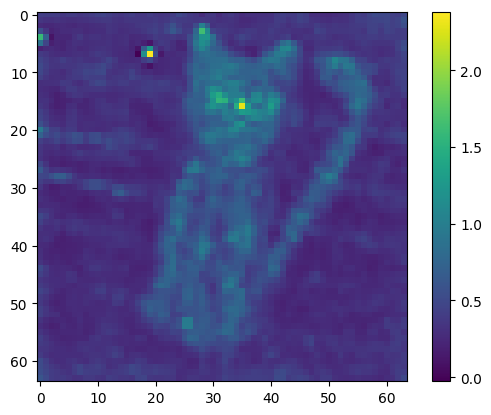

tensor(-8.5398) tensor(35.9903)


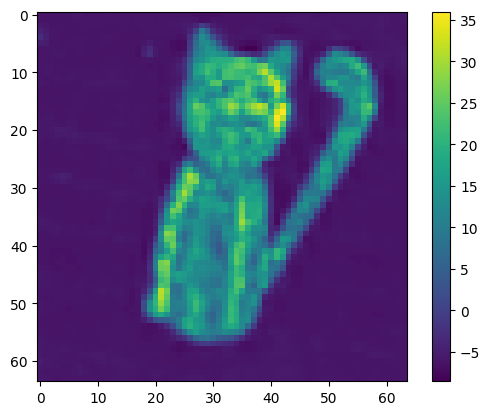

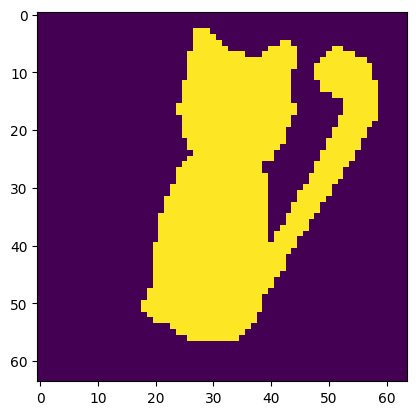

In [39]:
# print(pred_map.shape)
pred_map.view(train_dataset.mask_size,train_dataset.mask_size,-1)

import matplotlib.pyplot as plt
# render pred_map with matplotlib
from google.colab.patches import cv2_imshow
import cv2

min = pred_map.min()
max = pred_map.max()
# print(min,max)

new_pred_map = pred_map# (pred_map - min) / (max - min)

for i in range(len(cls_token_ids)):
  mini_pred_map = pred_map.view(train_dataset.mask_size,train_dataset.mask_size,-1)[:,:,i]
  print(mini_pred_map.min(),mini_pred_map.max())

  plt.imshow(mini_pred_map)
  plt.colorbar()
  plt.show()

deep_map = pred_map.view(train_dataset.mask_size,train_dataset.mask_size,-1).numpy()
bin_map = deep_map[:,:,1]>0
plt.imshow(bin_map)

In [42]:
cross_layer_multiplier.weight.data,self_layer_multiplier.weight.data

(tensor([-0.3895,  3.7423,  2.3732,  1.5280,  4.4995], device='cuda:0'),
 tensor([3.1552, 1.7314, 1.6081], device='cuda:0'))

## Run the code with your newly trained model
If you have just trained your model with the code above, use the block below to run it

To save this concept for re-using, download the `learned_embeds.bin` file or save it on the library of concepts.

Use the [Stable Conceptualizer notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) for inference with persistently saved pre-trained concepts

In [ ]:
#@title Save your newly created concept to the [library of concepts](https://huggingface.co/sd-concepts-library)?

save_concept_to_public_library = True #@param {type:"boolean"}
name_of_your_concept = "Cat toy" #@param {type:"string"}
#@markdown `hf_token_write`: leave blank if you logged in with a token with `write access` in the [Initial Setup](#scrollTo=KbzZ9xe6dWwf). If not, [go to your tokens settings and create a write access token](https://huggingface.co/settings/tokens)
hf_token_write = "" #@param {type:"string"}

if(save_concept_to_public_library):
  from slugify import slugify
  from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
  from huggingface_hub import create_repo
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  output_dir = hyperparameters["output_dir"]
  if(not hf_token_write):
    with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();
  else:
    hf_token = hf_token_write
  #Join the Concepts Library organization if you aren't part of it already
  !curl -X POST -H 'Authorization: Bearer '$hf_token -H 'Content-Type: application/json' https://huggingface.co/organizations/sd-concepts-library/share/VcLXJtzwwxnHYCkNMLpSJCdnNFZHQwWywv
  images_upload = os.listdir("my_concept")
  image_string = ""
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  for i, image in enumerate(images_upload):
      image_string = f'''{image_string}![{placeholder_token} {i}](https://huggingface.co/{repo_id}/resolve/main/concept_images/{image})
'''
  if(what_to_teach == "style"):
      what_to_teach_article = f"a `{what_to_teach}`"
  else:
      what_to_teach_article = f"an `{what_to_teach}`"
  readme_text = f'''---
license: mit
base_model: {pretrained_model_name_or_path}
---
### {name_of_your_concept} on Stable Diffusion
This is the `{placeholder_token}` concept taught to Stable Diffusion via Textual Inversion. You can load this concept into the [Stable Conceptualizer](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) notebook. You can also train your own concepts and load them into the concept libraries using [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb).

Here is the new concept you will be able to use as {what_to_teach_article}:
{image_string}
'''
  #Save the readme to a file
  readme_file = open("README.md", "w")
  readme_file.write(readme_text)
  readme_file.close()
  #Save the token identifier to a file
  text_file = open("token_identifier.txt", "w")
  text_file.write(placeholder_token)
  text_file.close()
  #Save the type of teached thing to a file
  type_file = open("type_of_concept.txt","w")
  type_file.write(what_to_teach)
  type_file.close()
  operations = [
    CommitOperationAdd(path_in_repo="learned_embeds.bin", path_or_fileobj=f"{output_dir}/learned_embeds.bin"),
    CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
    CommitOperationAdd(path_in_repo="type_of_concept.txt", path_or_fileobj="type_of_concept.txt"),
    CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
  ]
  create_repo(repo_id,private=True, token=hf_token)
  api = HfApi()
  api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message=f"Upload the concept {name_of_your_concept} embeds and token",
    token=hf_token
  )
  api.upload_folder(
    folder_path=save_path,
    path_in_repo="concept_images",
    repo_id=repo_id,
    token=hf_token
  )

In [ ]:
#@title Set up the pipeline
from diffusers import DPMSolverMultistepScheduler
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    scheduler=DPMSolverMultistepScheduler.from_pretrained(hyperparameters["output_dir"], subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

In [ ]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "a \u003Ccat-toy> inside ramen-bowl" #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=30, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid